# *Title**

# Introduction

test

# Preliminary Results

In [4]:
#install.packages("tidymodels")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘Rcpp’, ‘diagram’, ‘lava’, ‘listenv’, ‘parallelly’, ‘prodlim’, ‘future’, ‘warp’, ‘iterators’, ‘lhs’, ‘DiceDesign’, ‘patchwork’, ‘globals’, ‘clock’, ‘gower’, ‘ipred’, ‘timeDate’, ‘furrr’, ‘slider’, ‘foreach’, ‘GPfit’, ‘modelenv’, ‘dials’, ‘hardhat’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘recipes’, ‘rsample’, ‘tune’, ‘workflows’, ‘workflowsets’, ‘yardstick’




In [5]:
library(tidyverse)
library(tidymodels)
options(repr.plot.width = 10, repr.plot.height = 8)
options(repr.matrix.max.rows = 6)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.0 ──

✔ broom        1.0.5     ✔ rsample      1.1.1
✔ dials        1.2.0     ✔ tune         1.1.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.0     ✔ yardstick    1.2.0
✔ recipes      1.0.6     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages



In [25]:
# Grabbing the data
url <- "https://gist.githubusercontent.com/zhonglism/f146a9423e2c975de8d03c26451f841e/raw/f79e190df4225caed58bf360d8e20a9fa872b4ac/vgsales.csv"
#Reading data into R
gaming_dataset <- read_csv(url)
#Selecting columns we need for our analysis
gaming_data <- gaming_dataset %>%
filter(
Platform %in% c("Wii", "DS"),
NA_Sales > 1,
JP_Sales > 1) %>%
select(Platform, NA_Sales, JP_Sales)

gaming_data

Rows: 16598 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Name, Platform, Year, Genre, Publisher
dbl (6): Rank, NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Platform,NA_Sales,JP_Sales
<chr>,<dbl>,<dbl>
Wii,41.49,3.77
Wii,15.85,3.79
Wii,15.75,3.28
⋮,⋮,⋮
Wii,1.87,1.32
DS,1.57,1.19
DS,1.47,1.10


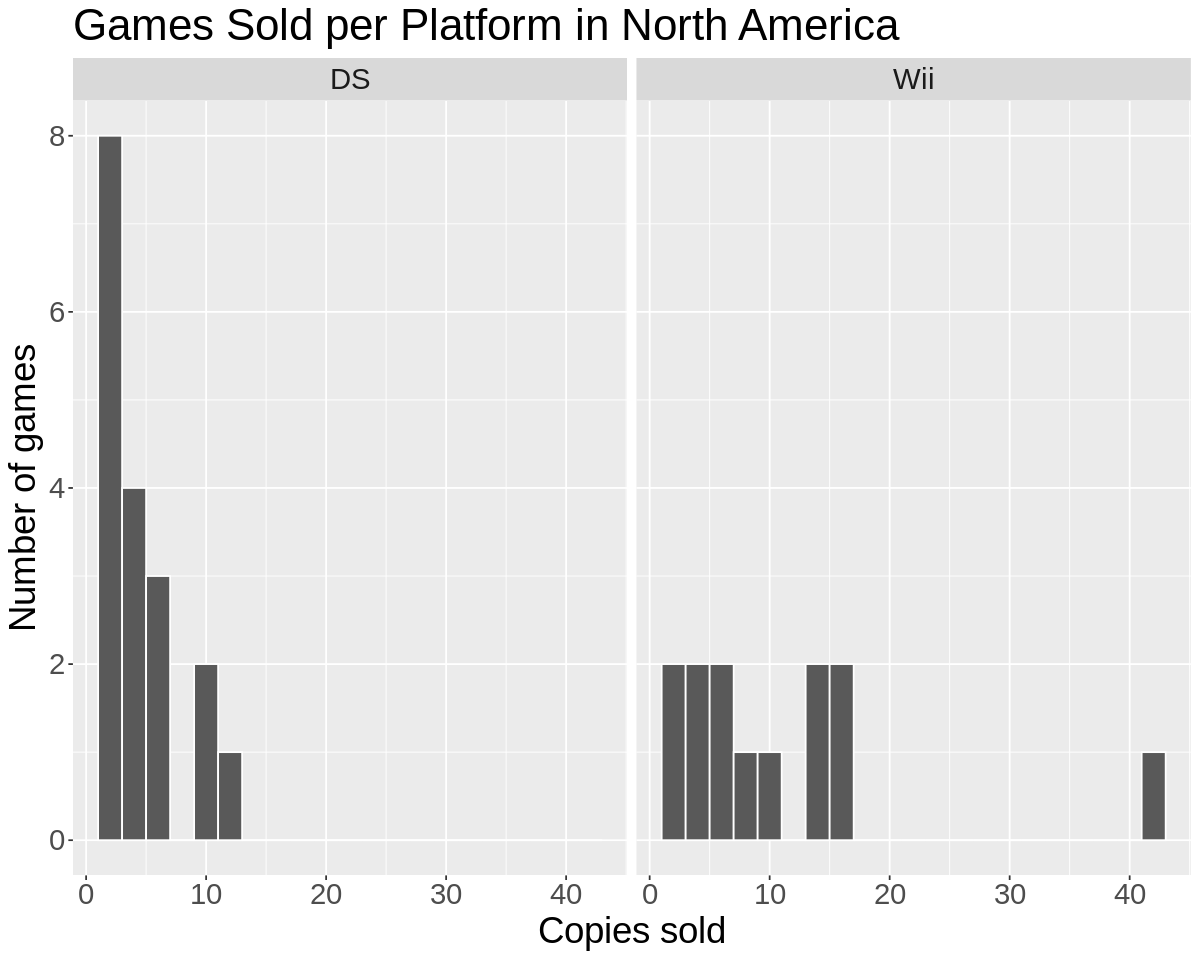

In [26]:
#Comparing the sampling distributions of DS and Wii in North America
gaming_data_dist_NA <-
gaming_data %>%
ggplot() +
geom_histogram(aes(x = NA_Sales),binwidth = 2, color = 'white') +
facet_wrap(~ Platform) +
xlab("Copies sold") +
ylab("Number of games") +
ggtitle("Games Sold per Platform in North America")+
theme(text = element_text(size = 22))
gaming_data_dist_NA

NULL

[1] 3

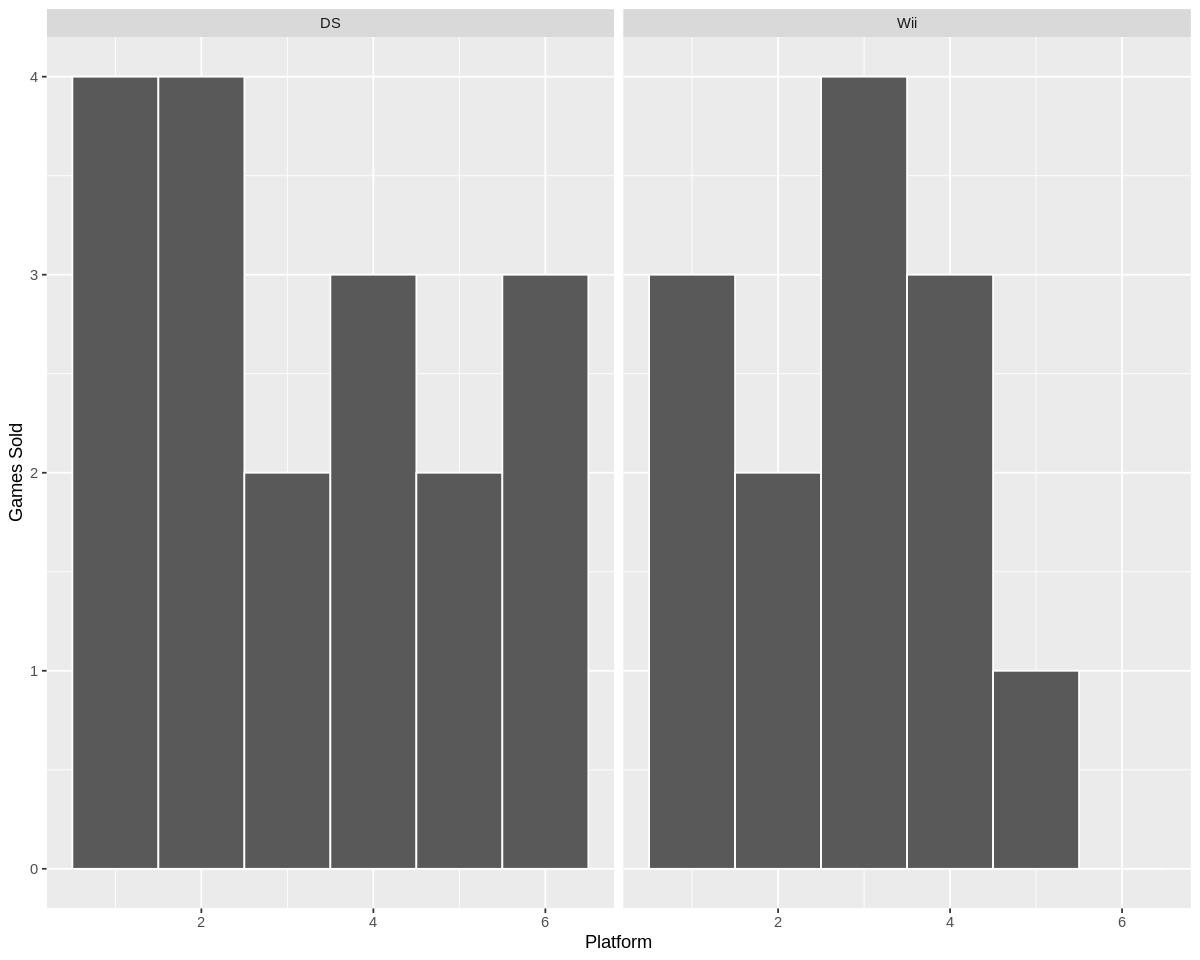

In [27]:
#Comparing the sampling distributions of DS and Wii in Japan
gaming_data_dist_JP <-

3

gaming_data %>%
ggplot() +
geom_histogram(aes(x = JP_Sales), binwidth = 1, color = 'white') +
facet_wrap(~ Platform) +
xlab("Platform") +
ylab("Games Sold")
ggtitle("Games Sold per Platform in Japan")+
theme(text = element_text(size = 22))
gaming_data_dist_JP

In [28]:
#calculating the sample means
sample_means <- gaming_data |>
    group_by(Platform) |>
    summarise(JP_Sales_Mean = mean(JP_Sales),
              NA_Sales_Mean = mean(NA_Sales))
sample_means

Platform,JP_Sales_Mean,NA_Sales_Mean
<chr>,<dbl>,<dbl>
DS,3.252222,4.468889
Wii,2.683077,11.028462


# Methods: Plan

# References